# Precipitation Extremes Analysis

### Start a dask distributed cluster

In [1]:
from ncar_jobqueue import NCARCluster
from dask.distributed import Client
import dask

In [2]:
cluster = NCARCluster(project='p06010014')

In [3]:
cluster.scale(5)

In [4]:
client = Client(cluster)

In [5]:
dask.config.set({'distributed.dashboard.link': "/proxy/{port}/status"});

In [6]:
client

Client Scheduler: tcp://10.148.0.6:45633 Dashboard: /proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### Load the file as an xarray dataset with dask enabled

In [7]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [8]:
#file_path = "/glade/scratch/nanr/forKatie/daily/"
file_path = "/glade/scratch/jet/katie/daily/"

In [9]:
var = "PRECT"

In [10]:
# ens002, historical
file = "b.e13.B20TRC5CN.ne120_g16.002.cam.h1.PRECT.19600101-20051231.regrid.23x0.31.nc"
# ens001, RCP8.5
#file = "b.e13.BRCP85C5CN.ne120_g16.001.cam.h1.PRECT.20700101-21001231.regrid.23x0.31.nc"
# ens002, RCP8.5 needs to be concatenated - separate files for each year
# ens 003, RCP8.5
#file = "b.e13.BRCP85C5CN.ne120_g16.003.cam.h1.PRECT.20700101-21001231.regrid.23x0.31.nc"

In [11]:
ds = xr.open_dataset(file_path+file, chunks={'time': 100, 'lat': 384, 'lon': 576})

### Read variable as a data array

In [12]:
PRECT = ds.PRECT # can I use the variable "var" somehow here to select the desired output variable?
PRECT

,Array,Chunk
Bytes,59.42 GB,88.47 MB
Shape,"(16790, 768, 1152)","(100, 384, 576)"
Count,673 Tasks,672 Chunks
Type,float32,numpy.ndarray


### Look at the array and chunk sizes

In [13]:
PRECT.data

,Array,Chunk
Bytes,59.42 GB,88.47 MB
Shape,"(16790, 768, 1152)","(100, 384, 576)"
Count,673 Tasks,672 Chunks
Type,float32,numpy.ndarray


### Read the variable into memory before computations and plotting

Use the progress bar to track time

In [14]:
from dask.diagnostics import ProgressBar

In [15]:
# progress bar isn't showing up anymore?
with ProgressBar():
    PRECT = PRECT.persist()

In [16]:
# To get timing, can also use:
#%time PRECT = PRECT.persist()

### Compute annual mean and plot

In [17]:
# This is fast now because it's a dask array
%time PRECT_amean = PRECT.mean(dim='time')
#PRECT_amean
PRECT_amean.data

CPU times: user 6.98 ms, sys: 0 ns, total: 6.98 ms
Wall time: 6.9 ms


dask.array<mean_agg-aggregate, shape=(768, 1152), dtype=float32, chunksize=(384, 576), chunktype=numpy.ndarray>

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs


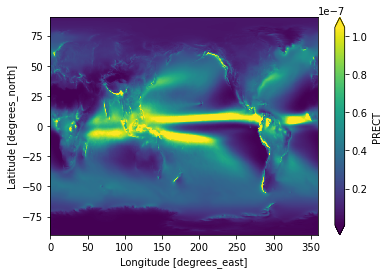

In [18]:
%time
PRECT_amean.plot(robust=True);

### Try using CDO within python

In [20]:
from cdo import *
cdo = Cdo()

Can try to follow this example for using CDO indices\
https://github.com/Peter-Gibson/climate/blob/CLIMATE-937/examples/ETCCDI_precip.py

Assign outputfile name

In [21]:
base_name = "b.e13.B20TRC5CN.ne120_g16.002.cam.h1.PRECT.19600101-20051231.regrid.23x0.31"

In [22]:
# convert to mm/day
PRECT_mm = PRECT*1000*86400

Here we use the yearmax function to calculate consecutive days ('consects') with less than ('lec') 1 mm precip

I don't yet know what "options=-L" does

In [ ]:
help(cdo.yearmax)

In [28]:
cdo.yearmax(input='-consects -lec,1 '+ PRECT_mm, output=base_name+'_'+'cdd.nc', options='-L')

TypeError: can only concatenate str (not "Array") to str

### Subset data for CONUS

In [33]:
# http://en.wikipedia.org/wiki/Extreme_points_of_the_United_States#Westernmost
top = 49.3457868 # north lat
left = -124.7844079 # west long
right = -66.9513812 # east long
bottom =  24.7433195 # south lat

TO DO: how to subset land points only within this domain? Need a CAM landmask for this resolution (regridded...)

In [34]:
# Accounting for longitude conversion from -180,180 to 0,360
PRECT_CONUS = PRECT.sel(lat=slice(bottom,top),lon=slice(360+left,360+right))

In [35]:
PRECT_CONUS

<xarray.DataArray 'PRECT' (time: 11315, lat: 105, lon: 185)>
dask.array<getitem, shape=(11315, 105, 185), dtype=float32, chunksize=(100, 105, 185), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 24.76 24.99 25.23 25.46 ... 48.46 48.7 48.93 49.17
  * lon      (lon) float64 235.3 235.6 235.9 236.2 ... 291.9 292.2 292.5 292.8
  * time     (time) object 2070-01-02 00:00:00 ... 2101-01-01 00:00:00
Attributes:
    units:          m/s
    long_name:      Total (convective and large-scale) precipitation rate (li...
    cell_methods:   time: mean
    cell_measures:  area: area

In [36]:
PRECT_CONUS.data

,Array,Chunk
Bytes,879.18 MB,7.77 MB
Shape,"(11315, 105, 185)","(100, 105, 185)"
Count,570 Tasks,114 Chunks
Type,float32,numpy.ndarray


### Mask out where precip < 1 mm/day
or < 1/(1000*86400) m/s

In [37]:
p_dry = 1/(1000*86400) # m/s

In [38]:
p_dry

1.1574074074074074e-08

In [39]:
PRECT_CONUS_mask = PRECT_CONUS.where(PRECT_CONUS >= p_dry)

In [40]:
PRECT_CONUS_mask

<xarray.DataArray 'PRECT' (time: 11315, lat: 105, lon: 185)>
dask.array<where, shape=(11315, 105, 185), dtype=float32, chunksize=(100, 105, 185), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 24.76 24.99 25.23 25.46 ... 48.46 48.7 48.93 49.17
  * lon      (lon) float64 235.3 235.6 235.9 236.2 ... 291.9 292.2 292.5 292.8
  * time     (time) object 2070-01-02 00:00:00 ... 2101-01-01 00:00:00
Attributes:
    units:          m/s
    long_name:      Total (convective and large-scale) precipitation rate (li...
    cell_methods:   time: mean
    cell_measures:  area: area

In [41]:
time0_mask = PRECT_CONUS_mask[0,:,:]

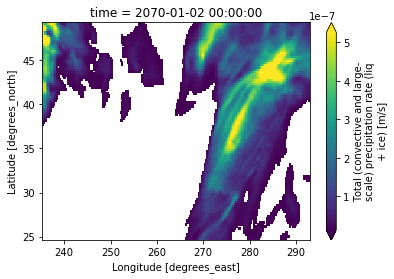

In [42]:
time0_mask.plot(robust=True);

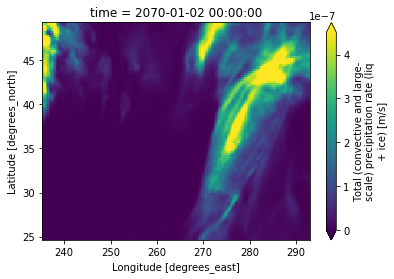

In [43]:
# without dry points masked out
time0 = PRECT_CONUS[0,:,:]
time0.plot(robust=True);

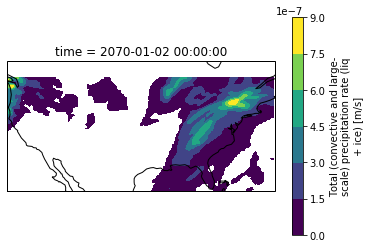

In [44]:
import cartopy.crs as ccrs
ax = plt.axes(projection=ccrs.PlateCarree())
PRECT_CONUS_mask.isel(time=0).plot.contourf(ax=ax, transform=ccrs.PlateCarree());
ax.set_extent([360+left,360+right,bottom,top])
ax.coastlines();

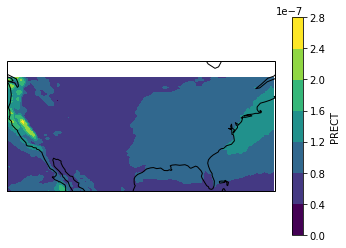

In [45]:
ax = plt.axes(projection=ccrs.PlateCarree())
PRECT_CONUS_mask.mean(dim='time').plot.contourf(ax=ax, transform=ccrs.PlateCarree());
ax.set_extent([360+left,360+right,bottom,top])
ax.coastlines();
# This shows all points have at least some data (i.e., no gridpoint is masked for all time points)

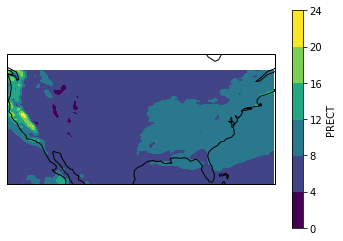

In [46]:
# convert to mm/day
PRECT_CONUS_mask_mm = PRECT_CONUS_mask*1000*86400
ax = plt.axes(projection=ccrs.PlateCarree())
PRECT_CONUS_mask_mm.mean(dim='time').plot.contourf(ax=ax, transform=ccrs.PlateCarree());
ax.set_extent([360+left,360+right,bottom,top])
ax.coastlines();

### Compute the 90th percentile for each gridpoint including only non-dry days

TO DO: seasonal quantiles?

In [51]:
# Here we have to use compute since quantile doesn't operate on dask arrays (?)
# But it is still relatively fast
%time
p90 = PRECT_CONUS_mask_mm.compute().quantile(0.9, dim='time')

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


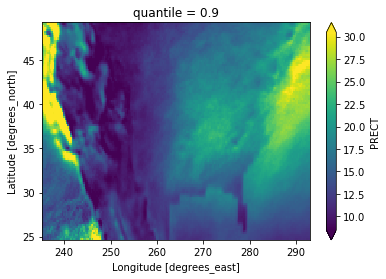

In [58]:
p90.plot(robust=True);

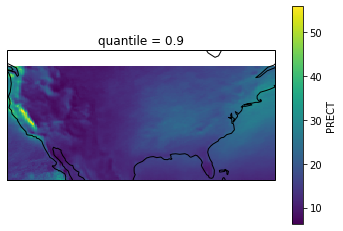

In [59]:
ax = plt.axes(projection=ccrs.PlateCarree())
p90.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree());
#p90.plot.contourf(ax=ax, transform=ccrs.PlateCarree());
ax.set_extent([360+left,360+right,bottom,top])
ax.coastlines();

Close client/cluser and release workers when you're done

In [29]:
client.close()
cluster.close()